In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error as RMSE
import warnings
warnings.filterwarnings('ignore')
import requests
import json
import time
import plotly.express as px
import plotly.graph_objects as go
import copy

In [ ]:
def get_radiation_data(start_year, end_year):

    token = 'your renewable ninja token here'
    api_base = 'https://www.renewables.ninja/api/'

    s = requests.session()
    s.headers = {'Authorization': 'Token ' + token} # Send token header with each request
    url = api_base + 'data/pv'

    ###### PV data request
    DATA = pd.DataFrame()
    for year in range(start_year, end_year+1):

        args = {
            'lat': 35.4215,
            'lon': 51.4881,
            'date_from': f'{year}-01-01',
            'date_to': f'{year}-12-31',
            'dataset': 'merra2',
            'capacity': 1.0,
            'system_loss': 0,
            'tracking': 0,
            'tilt': 35,     # should be equal to latitude value for good annual performance
            'azim': 180,
            'format': 'json',
            'raw': True,
            'header': False
        }

        r = s.get(url, params=args)

        # Parse JSON to get a pandas.DataFrame of data and dict of metadata
        parsed_response = json.loads(r.text)

        data = pd.read_json(json.dumps(parsed_response), orient='index')
        data[f'total_irradiance_{year}'] = data['irradiance_direct'] + data['irradiance_diffuse'] # kWh/m2
        data = data.drop(columns=['electricity','irradiance_direct','irradiance_diffuse','temperature'])

        data = data.reset_index(drop=True)

        DATA = pd.concat([DATA, data], axis=1)

        time.sleep(5)

    if len(DATA) > 8760:
        DATA = DATA.iloc[:8760]

    DATA = DATA * 1000 # kWh/m2 to Wh/m2

    return DATA

In [3]:
start_year = 2000
end_year = 2023
data = get_radiation_data(start_year = start_year, end_year=end_year)

In [4]:
temp_mean = data.mean(axis=1)
temp_max = data.max(axis=1)
temp_min = data.min(axis=1)
temp_std = data.std(axis=1)

data['mean'] = temp_mean
data['max'] = temp_max
data['min'] = temp_min
data['std'] = temp_std

In [5]:
px.line(data, y='mean', title="Mean Solar Radiation (Wh/m2)")

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=data['max'], mode='lines', name='Max'))
fig.add_trace(go.Scatter(y=data['min'], mode='lines', name='Min'))

# plot without range selector
# fig.update_layout(title="Max & Min Plot", xaxis_title="Index", yaxis_title="Value")

# plot with range selector
fig.update_layout(
    title="Hourly Min & MAX (Wh/m2)",
    xaxis_title="Index",
    yaxis_title="Value",
    xaxis=dict(
        rangeslider=dict(visible=True),  # Show the range slider below the plot
        type="linear",  # Type of x-axis
        tickmode="array",  # Set x-axis ticks
        tickvals=list(range(0, len(data), 168)),  # Set weekly x-axis ticks at intervals
        ticktext=[f'{i}' for i in range(0, len(data), 168)]  # Display x-axis ticks as 0, 168, 336...
    )
)

fig.show()

In [7]:
data['upper'] = data['mean'] + 2 * data['std']
data['lower'] = data['mean'] - 2 * data['std']
data['lower'] = data['lower'].clip(lower=0)

fig = go.Figure()
fig.add_trace(go.Scatter(y=data['mean'], mode='lines', name='Mean', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=data['upper'], mode='lines', name='Upper Bound (+2 std)', line=dict(color='red', width=0.5)))
fig.add_trace(go.Scatter(y=data['lower'], mode='lines', name='Lower Bound (-2 std)', line=dict(color='red', width=0.5)))

# Add shaded area between upper and lower bound (±2 std range)
fig.add_trace(go.Scatter(
    x=data.index, y=data['upper'], fill='tonexty', fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'), name='2 Std Range', showlegend=False))

# plot without range selector
# fig.update_layout(title="Mean with ±2 Std Deviation Range", xaxis_title="Index", yaxis_title="Value")
# plot with range selector
fig.update_layout(
    title="Hourly Mean with ±2 Std Deviation Range (Wh/m2)",
    xaxis_title="Index",
    yaxis_title="Value",
    xaxis=dict(
        rangeslider=dict(visible=True),  # Show the range slider below the plot
        type="linear",  # Type of x-axis
        tickmode="array",  # Set x-axis ticks
        tickvals=list(range(0, len(data), 168)),  # Set x-axis ticks at intervals
        ticktext=[f'{i}' for i in range(0, len(data), 168)]  # Display x-axis ticks as 0, 24, 48...
    )
)

fig.show()

Text(0.5, 1.0, 'Distribution of Mean hourly Solar Radiation')

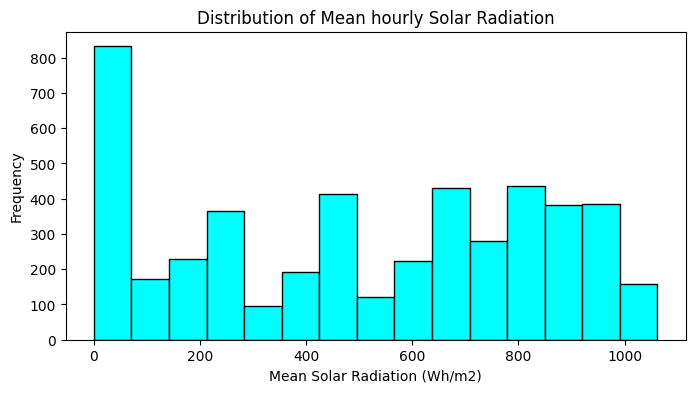

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(data[data['mean']>0]['mean'], edgecolor='black', color='cyan', density=False, bins = 'fd');
plt.ylabel('Frequency')
plt.xlabel('Mean Solar Radiation (Wh/m2)')
plt.title('Distribution of Mean hourly Solar Radiation')

Text(0.5, 1.0, 'Total Solar Radiation per Year')

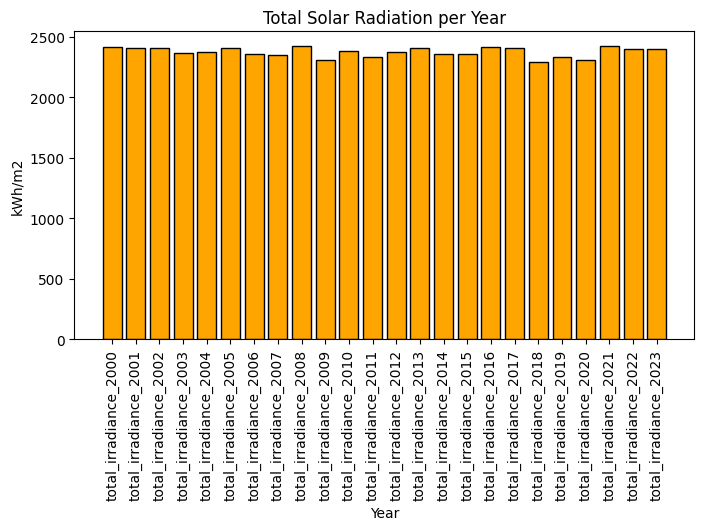

In [9]:
plt.figure(figsize=(8, 4))
plt.bar(data.sum(axis=0).iloc[:-6].index, data.sum(axis=0).iloc[:-6].values/1000, edgecolor='black', color='orange') # /1000 to chnage Wh to kWh
plt.ylabel('kWh/m2')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.title('Total Solar Radiation per Year')

In [10]:
data = data.iloc[:, :-6] # remove mean, std, max, min, upper(mean+2std), lower(mean-2std)
data['mean_prev_year'] = data.iloc[:,:-1].mean(axis=1) # claculate mean radiation in previous years to be used as an input feature
data = data.iloc[:,-2:] # remove previous years data

In [11]:
# add lagged features to the dataset
for lag in range(1, 4):
    data[f'total_irradiance_{end_year}_lag_{lag}'] = data[f'total_irradiance_{end_year}'].shift(lag)
data.dropna(inplace=True) # drop rows with NaN values created as a result of lag features

In [12]:
# move the target variable (total_irrandiance_{end_year}) to the end of the dataframe
target = data.pop(f'total_irradiance_{end_year}')
data[f'total_irradiance_{end_year}'] = target

In [13]:
train_percentage = 0.8 # percentage of data in the train set
cutpoint = int(train_percentage*len(data)) # find the cutpoint to separate train and test data

train = data[:cutpoint]
test = data[cutpoint:]

y_train, X_train = train.iloc[:,-1].values, train.iloc[:,:-1].values
y_test, X_test = test.iloc[:,-1].values, test.iloc[:,:-1].values

In [14]:
MMS = MinMaxScaler()
X_train = MMS.fit_transform(X_train)
X_test = MMS.transform(X_test)

In [15]:
model = MLPRegressor((80,80,), solver='lbfgs', random_state=1)

In [16]:
model.fit(X_train, y_train);

In [17]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# integrating domain knowledge to prevent having negative values right at the
# start of the night
y_train_pred = np.where(X_train[:,0] == 0, 0, y_train_pred)
y_test_pred = np.where(X_test[:,0] == 0, 0, y_test_pred)

rmse_train = RMSE(y_train, y_train_pred)
rmse_test = RMSE(y_test, y_test_pred)

print('RMSE on train data: ', rmse_train)
print('RMSE on test data: ', rmse_test)

RMSE on train data:  28.618600762619522
RMSE on test data:  34.76462549832477


In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=y_test_pred, mode='lines', name='Predicted'))

# plot with range selector
fig.update_layout(
    title="Test performance",
    xaxis_title="Index",
    yaxis_title="Value",
    xaxis=dict(
        rangeslider=dict(visible=True),  # Show the range slider below the plot
        type="linear",  # Type of x-axis
        tickmode="array",  # Set x-axis ticks
        tickvals=list(range(0, len(y_test), 24)),  # Set weekly x-axis ticks at intervals
        ticktext=[f'{i}' for i in range(0, len(y_test), 24)]  # Display x-axis ticks as 0, 168, 336...
    )
)

fig.show()

Text(0.5, 1.0, 'Test')

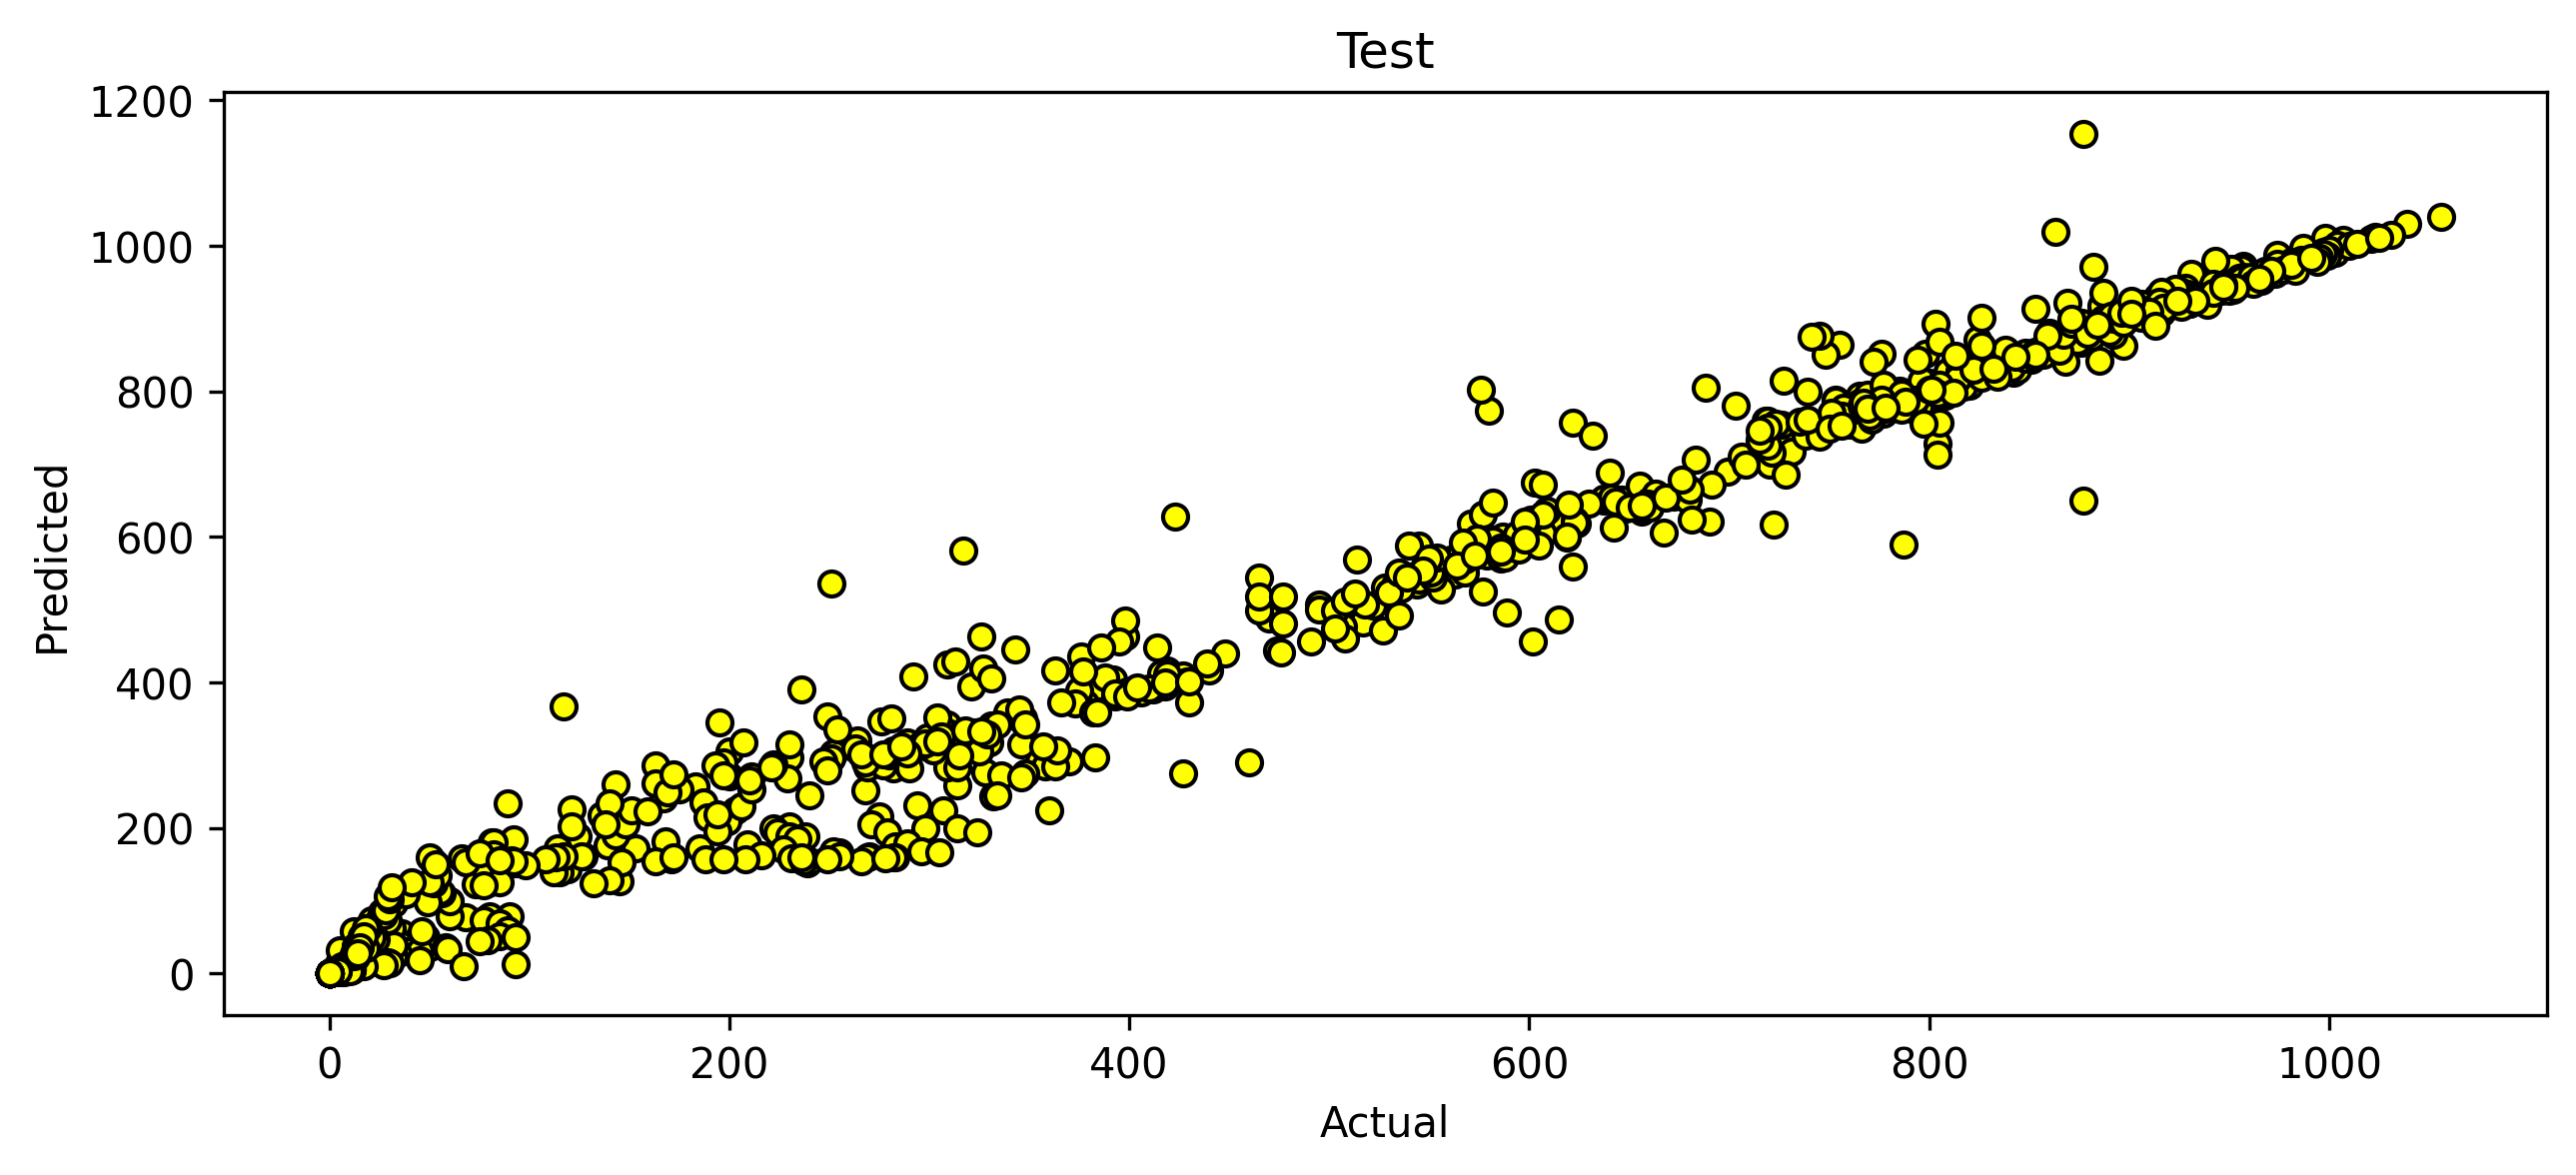

In [19]:
plt.figure(figsize=(10,4), dpi=300)
plt.scatter(y_test, y_test_pred, edgecolor='black', color='yellow')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test')

Text(0.5, 1.0, 'Train')

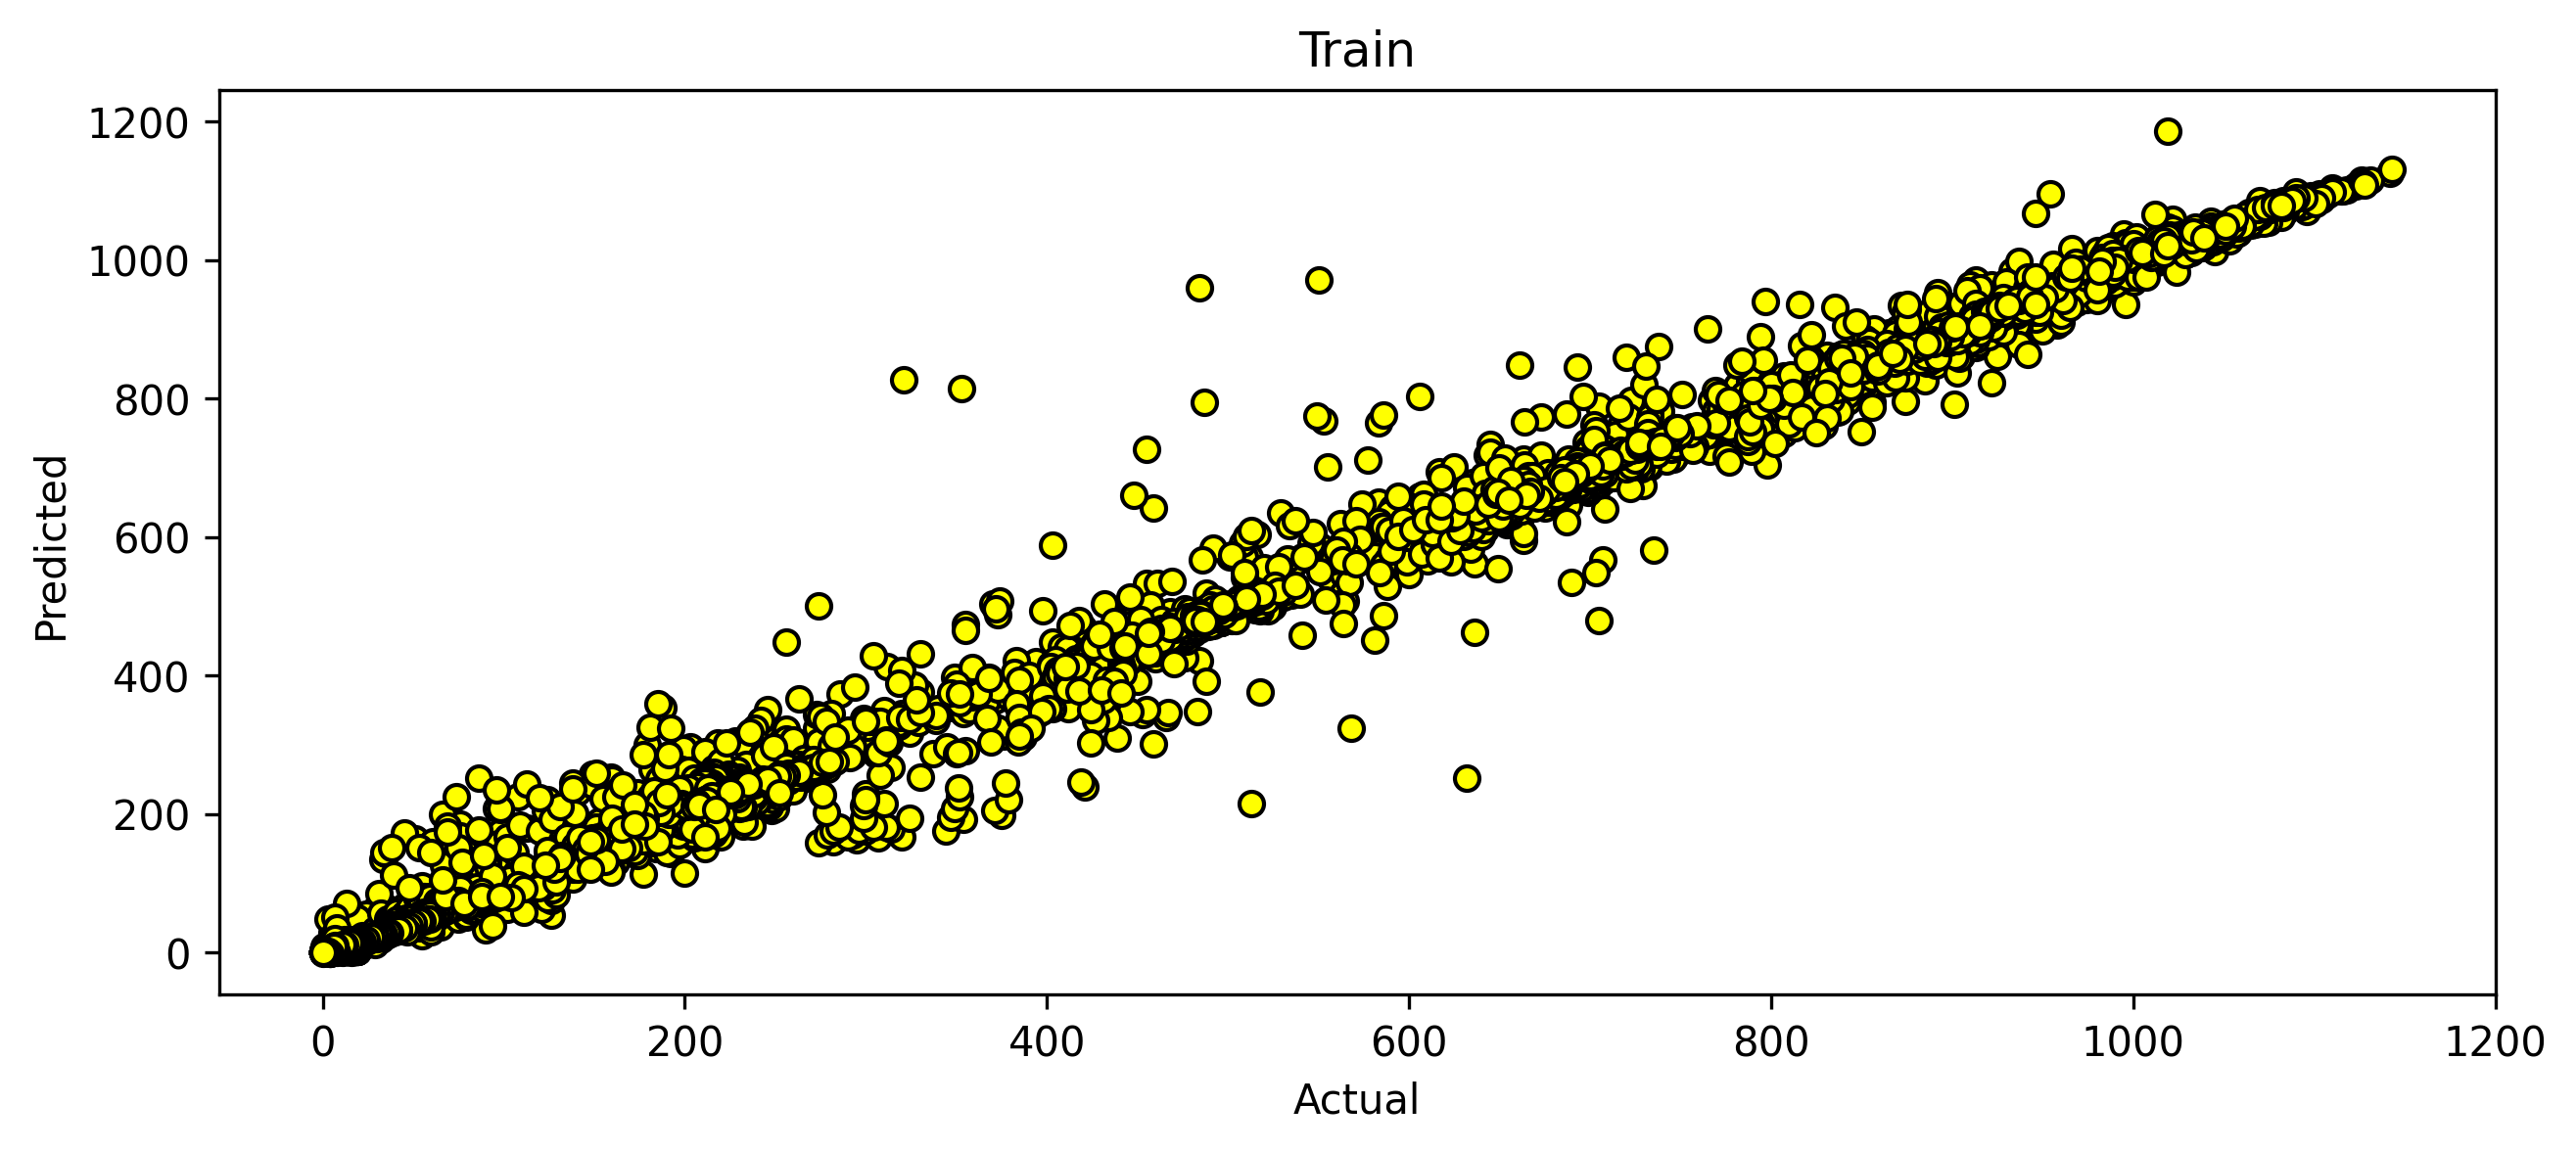

In [20]:
plt.figure(figsize=(10,4), dpi=300)
plt.scatter(y_train, y_train_pred, edgecolor='black', color='yellow')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Train')

In [21]:
# series multistep prediction
# the model uses its own predictions to make new predictions

test_copy = copy.deepcopy(test)

update_every = 6 # every 6 hours use the real data istead of models predictions to make new predictions
predictions = []
for i in range(len(test_copy)):

    if test_copy.iloc[i,0] == 0: # column 0 is the mean value, if its zero it means that it is night
        prediction = 0
    else:
        xTest = MMS.transform(test_copy.iloc[i,:-1].values.reshape(1, -1)) # omit the last column (target) and transform
        prediction = model.predict(xTest)[0]

    predictions.append(prediction)

    if i != len(test_copy) -1:
        if i % update_every != 0:
            test_copy.iloc[i+1,1] = prediction           # column 1 is the first lag which takes the predicted value of the previous time step
            test_copy.iloc[i+1,2] = test_copy.iloc[i,1]  # column 2 is the second lag which takes the value of first lag of the previous time step
            test_copy.iloc[i+1,3] = test_copy.iloc[i,2]  # column 3 is the third lag which takes the value of second lag of the previous time step

In [22]:
rmse_test_multistep = RMSE(y_test, predictions)
print('RMSE on test data (multistep): ', rmse_test_multistep)
print(f'CVRMSE = {rmse_test_multistep/y_test[np.where(y_test>0)].mean()}')

RMSE on test data (multistep):  92.85571682251069
CVRMSE = 0.19018492411409615


In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=predictions, mode='lines', name='6 hours predictions'))

# plot with range selector
fig.update_layout(
    title="Test performance",
    xaxis_title="Index",
    yaxis_title="Value",
    xaxis=dict(
        rangeslider=dict(visible=True),  # Show the range slider below the plot
        type="linear",  # Type of x-axis
        tickmode="array",  # Set x-axis ticks
        tickvals=list(range(0, len(y_test), 24)),  # Set weekly x-axis ticks at intervals
        ticktext=[f'{i}' for i in range(0, len(y_test), 24)]  # Display x-axis ticks as 0, 168, 336...
    )
)

fig.show()

In [41]:
# parallel multi step
data_copy = copy.deepcopy(data)
# creating the datasets
for lag in range(-1,-6,-1):
    data_copy[f'total_irradiance_2023_next_{-lag}'] = data_copy['total_irradiance_2023'].shift(lag)
    data_copy[f'mean_prev_year_next_{-lag}'] = data_copy['mean_prev_year'].shift(lag)
data_copy.dropna(inplace=True)

In [42]:
train_percentage = 0.8
cutpoint = int(train_percentage*len(data_copy))

#################

data_now = data_copy[['mean_prev_year','total_irradiance_2023_lag_1','total_irradiance_2023_lag_2',
                      'total_irradiance_2023_lag_3','total_irradiance_2023']]
train = data_now[:cutpoint]
test = data_now[cutpoint:]

y_train_now, X_train_now = train.iloc[:,-1].values, train.iloc[:,:-1].values
y_test_now, X_test_now = test.iloc[:,-1].values, test.iloc[:,:-1].values

MMS_now = MinMaxScaler()
X_train_now = MMS_now.fit_transform(X_train_now)
X_test_now = MMS_now.transform(X_test_now)

#################

data_next_1 = data_copy[['mean_prev_year_next_1','total_irradiance_2023_lag_1','total_irradiance_2023_lag_2',
                         'total_irradiance_2023_lag_3','total_irradiance_2023_next_1']]
train = data_next_1[:cutpoint]
test = data_next_1[cutpoint:]

y_train_next_1, X_train_next_1 = train.iloc[:,-1].values, train.iloc[:,:-1].values
y_test_next_1, X_test_next_1 = test.iloc[:,-1].values, test.iloc[:,:-1].values

MMS_next_1 = MinMaxScaler()
X_train_next_1 = MMS_next_1.fit_transform(X_train_next_1)
X_test_next_1 = MMS_next_1.transform(X_test_next_1)

#################

data_next_2 = data_copy[['mean_prev_year_next_2','total_irradiance_2023_lag_1','total_irradiance_2023_lag_2',
                         'total_irradiance_2023_lag_3','total_irradiance_2023_next_2']]
train = data_next_2[:cutpoint]
test = data_next_2[cutpoint:]

y_train_next_2, X_train_next_2 = train.iloc[:,-1].values, train.iloc[:,:-1].values
y_test_next_2, X_test_next_2 = test.iloc[:,-1].values, test.iloc[:,:-1].values

MMS_next_2 = MinMaxScaler()
X_train_next_2 = MMS_next_2.fit_transform(X_train_next_2)
X_test_next_2 = MMS_next_2.transform(X_test_next_2)

#################
data_next_3 = data_copy[['mean_prev_year_next_3','total_irradiance_2023_lag_1','total_irradiance_2023_lag_2',
                         'total_irradiance_2023_lag_3','total_irradiance_2023_next_3']]
train = data_next_3[:cutpoint]
test = data_next_3[cutpoint:]

y_train_next_3, X_train_next_3 = train.iloc[:,-1].values, train.iloc[:,:-1].values
y_test_next_3, X_test_next_3 = test.iloc[:,-1].values, test.iloc[:,:-1].values

MMS_next_3 = MinMaxScaler()
X_train_next_3 = MMS_next_3.fit_transform(X_train_next_3)
X_test_next_3 = MMS_next_3.transform(X_test_next_3)

#################
data_next_4 = data_copy[['mean_prev_year_next_4','total_irradiance_2023_lag_1','total_irradiance_2023_lag_2',
                         'total_irradiance_2023_lag_3','total_irradiance_2023_next_4']]
train = data_next_4[:cutpoint]
test = data_next_4[cutpoint:]

y_train_next_4, X_train_next_4 = train.iloc[:,-1].values, train.iloc[:,:-1].values
y_test_next_4, X_test_next_4 = test.iloc[:,-1].values, test.iloc[:,:-1].values

MMS_next_4 = MinMaxScaler()
X_train_next_4 = MMS_next_4.fit_transform(X_train_next_4)
X_test_next_4 = MMS_next_4.transform(X_test_next_4)

#################
data_next_5 = data_copy[['mean_prev_year_next_5','total_irradiance_2023_lag_1','total_irradiance_2023_lag_2',
                         'total_irradiance_2023_lag_3','total_irradiance_2023_next_5']]
train = data_next_5[:cutpoint]
test = data_next_5[cutpoint:]

y_train_next_5, X_train_next_5 = train.iloc[:,-1].values, train.iloc[:,:-1].values
y_test_next_5, X_test_next_5 = test.iloc[:,-1].values, test.iloc[:,:-1].values

MMS_next_5 = MinMaxScaler()
X_train_next_5 = MMS_next_5.fit_transform(X_train_next_5)
X_test_next_5 = MMS_next_5.transform(X_test_next_5)

In [43]:
model_now = MLPRegressor((80,80,), solver='lbfgs', random_state=1)
model_now.fit(X_train_now, y_train_now);

model_next_1 = MLPRegressor((80,80,), solver='lbfgs', random_state=1)
model_next_1.fit(X_train_next_1, y_train_next_1);

model_next_2 = MLPRegressor((80,80,), solver='lbfgs', random_state=1)
model_next_2.fit(X_train_next_2, y_train_next_2);

model_next_3 = MLPRegressor((80,80,), solver='lbfgs', random_state=1)
model_next_3.fit(X_train_next_3, y_train_next_3);

model_next_4 = MLPRegressor((80,80,), solver='lbfgs', random_state=1)
model_next_4.fit(X_train_next_4, y_train_next_4);

model_next_5 = MLPRegressor((80,80,), solver='lbfgs', random_state=1)
model_next_5.fit(X_train_next_5, y_train_next_5);

In [56]:
y_test_pred_now = model_now.predict(X_test_now)
y_test_pred_now = np.where(X_test_now[:,0] == 0, 0, y_test_pred_now)
rmse_test_now = RMSE(y_test_now, y_test_pred_now)

y_test_pred_next_1 = model_next_1.predict(X_test_next_1)
y_test_pred_next_1 = np.where(X_test_next_1[:,0] == 0, 0, y_test_pred_next_1)
rmse_test_next_1 = RMSE(y_test_next_1, y_test_pred_next_1)

y_test_pred_next_2 = model_next_2.predict(X_test_next_2)
y_test_pred_next_2 = np.where(X_test_next_2[:,0] == 0, 0, y_test_pred_next_2)
rmse_test_next_2 = RMSE(y_test_next_2, y_test_pred_next_2)

y_test_pred_next_3 = model_next_3.predict(X_test_next_3)
y_test_pred_next_3 = np.where(X_test_next_3[:,0] == 0, 0, y_test_pred_next_3)
rmse_test_next_3 = RMSE(y_test_next_3, y_test_pred_next_3)

y_test_pred_next_4 = model_next_4.predict(X_test_next_4)
y_test_pred_next_4 = np.where(X_test_next_4[:,0] == 0, 0, y_test_pred_next_4)
rmse_test_next_4 = RMSE(y_test_next_4, y_test_pred_next_4)

y_test_pred_next_5 = model_next_5.predict(X_test_next_5)
y_test_pred_next_5 = np.where(X_test_next_5[:,0] == 0, 0, y_test_pred_next_5)
rmse_test_next_5 = RMSE(y_test_next_5, y_test_pred_next_5)

print('RMSE on test now: ', rmse_test_now)
print('RMSE on test next 1: ', rmse_test_next_1)
print('RMSE on test next 2: ', rmse_test_next_2)
print('RMSE on test next 3: ', rmse_test_next_3)
print('RMSE on test next 4: ', rmse_test_next_4)
print('RMSE on test next 5: ', rmse_test_next_5)

RMSE on test now:  36.16364760364974
RMSE on test next 1:  69.75111970809955
RMSE on test next 2:  88.83270975184016
RMSE on test next 3:  98.85447634065515
RMSE on test next 4:  106.93178394903988
RMSE on test next 5:  112.44353821862495


In [64]:
X_test_now[0]

array([0., 0., 0., 0.])

In [101]:
predictions = []
for i in range(0,len(X_test_now),6):
    predictions.append(model_now.predict(X_test_now[i].reshape(1, -1))[0] if X_test_now[i,0]!=0 else 0)
    predictions.append(model_next_1.predict(X_test_next_1[i].reshape(1, -1))[0] if X_test_next_1[i,0]!=0 else 0)
    predictions.append(model_next_2.predict(X_test_next_2[i].reshape(1, -1))[0] if X_test_next_2[i,0]!=0 else 0)
    predictions.append(model_next_3.predict(X_test_next_3[i].reshape(1, -1))[0] if X_test_next_3[i,0]!=0 else 0)
    predictions.append(model_next_4.predict(X_test_next_4[i].reshape(1, -1))[0] if X_test_next_4[i,0]!=0 else 0)
    predictions.append(model_next_5.predict(X_test_next_5[i].reshape(1, -1))[0] if X_test_next_5[i,0]!=0 else 0)

predictions.pop()

0

In [102]:
RMSE(y_test_now,predictions)

86.77670025249017

In [103]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test_now, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=predictions, mode='lines', name='6 hours predictions'))

# plot with range selector
fig.update_layout(
    title="Test performance",
    xaxis_title="Index",
    yaxis_title="Value",
    xaxis=dict(
        rangeslider=dict(visible=True),  # Show the range slider below the plot
        type="linear",  # Type of x-axis
        tickmode="array",  # Set x-axis ticks
        tickvals=list(range(0, len(y_test), 24)),  # Set weekly x-axis ticks at intervals
        ticktext=[f'{i}' for i in range(0, len(y_test), 24)]  # Display x-axis ticks as 0, 168, 336...
    )
)

fig.show()